In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

# 데이터 읽기

In [2]:
origin_df = pd.read_csv("../data/basline_data.csv",index_col=['Date'],parse_dates=True)

In [3]:
origin_df.head()

,Open,High,Low,Close,Adj Close,Volume,next_price,next_rtn,log_return,CCI,...,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,KOSPI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,7068.327148,7109.184570,6913.069336,7027.469727,6893.216309,2256630,6813.062500,-0.005780,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1188.050049,410.359985,13.98,886.900024
2005-01-05,6913.069336,6978.440918,6815.011230,6945.754883,6813.062500,1773241,6853.140137,0.004728,-0.011696,NaN,...,NaN,NaN,-81.714844,NaN,NaN,NaN,1183.739990,404.250000,14.09,885.190002
2005-01-06,6978.440918,7305.299805,6847.697266,6986.612305,6853.140137,7480900,7085.585449,0.001171,0.005865,NaN,...,NaN,NaN,40.857422,NaN,NaN,NaN,1187.890015,402.140015,13.58,871.280029
2005-01-07,7043.812500,7231.756836,7019.298340,7223.585449,7085.585449,4612385,7253.907715,0.025522,0.033356,NaN,...,NaN,NaN,236.973145,196.115723,NaN,NaN,1186.189941,407.559998,13.49,870.840027
2005-01-10,7313.471680,7599.473145,7313.471680,7395.186035,7253.907715,4720077,7334.061523,0.011173,0.023478,NaN,...,NaN,NaN,171.600586,449.431152,NaN,NaN,1190.250000,406.250000,13.23,874.179993


In [4]:
origin_df['avg_price'] = origin_df['Close'].rolling(window=30).mean()

In [5]:
origin_df['avg_price'] = origin_df['Close'].rolling(window=1).mean()
#origin_df['avg_price'] = origin_df['avg_price'].shift(-7)
origin_df[['Close','avg_price']].head(10)

,Close,avg_price
Date,,
2005-01-04,7027.469727,7027.469727
2005-01-05,6945.754883,6945.754883
2005-01-06,6986.612305,6986.612305
2005-01-07,7223.585449,7223.585449
2005-01-10,7395.186035,7395.186035
2005-01-11,7476.900879,7476.900879
2005-01-12,7566.787109,7566.787109
2005-01-13,7517.758301,7517.758301
2005-01-14,7517.758301,7517.758301


In [6]:
origin_df['avg_price'].isnull().sum()

0

* shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.

In [7]:
n_list = [1,3,5,7,10,20,30,60,90]
for n in n_list:
    col_name = 'avg_price'+str(n)

    origin_df[col_name] = origin_df['Close'].rolling(window=n).mean()
    origin_df[col_name] = origin_df[col_name].shift(-n)
    # shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.
    diffs = origin_df[col_name]-origin_df['Close']
    label_name = 'label'+str(n)
    origin_df[label_name] = np.where(diffs>0,1,0)

다음날로부터 N일후 평균가격이 avg_pricen으로 들어가있는 것을 확인할 수 있습니다.

In [8]:
origin_df[['MA5','MA10','RASD5','RASD10','Close','avg_price1','avg_price10','avg_price5']].head(30)

,MA5,MA10,RASD5,RASD10,Close,avg_price1,avg_price10,avg_price5
Date,,,,,,,,
2005-01-04,NaN,NaN,NaN,NaN,7027.469727,6945.754883,7493.243896,7205.607910
2005-01-05,NaN,NaN,NaN,NaN,6945.754883,6986.612305,7582.312988,7329.814355
2005-01-06,NaN,NaN,NaN,NaN,6986.612305,7223.585449,7635.427588,7436.043555
2005-01-07,NaN,NaN,NaN,NaN,7223.585449,7395.186035,7664.027734,7494.878125
2005-01-10,7115.721680,NaN,NaN,NaN,7395.186035,7476.900879,7668.113477,7650.136230
2005-01-11,7205.607910,NaN,NaN,NaN,7476.900879,7566.787109,7647.684814,7780.879883
2005-01-12,7329.814355,NaN,NaN,NaN,7566.787109,7517.758301,7641.964795,7834.811621
2005-01-13,7436.043555,NaN,NaN,NaN,7517.758301,7517.758301,7617.450391,7834.811621
2005-01-14,7494.878125,NaN,152.913559,NaN,7517.758301,8171.476562,7578.227295,7833.177344


In [9]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4103 entries, 2005-01-04 to 2021-08-13
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         4103 non-null   float64
 1   High         4103 non-null   float64
 2   Low          4103 non-null   float64
 3   Close        4103 non-null   float64
 4   Adj Close    4103 non-null   float64
 5   Volume       4103 non-null   int64  
 6   next_price   4102 non-null   float64
 7   next_rtn     4103 non-null   float64
 8   log_return   4102 non-null   float64
 9   CCI          4090 non-null   float64
 10  MA5          4099 non-null   float64
 11  MA10         4094 non-null   float64
 12  RASD5        4095 non-null   float64
 13  RASD10       4090 non-null   float64
 14  MACD         4070 non-null   float64
 15  ATR          4089 non-null   float64
 16  ub           4084 non-null   float64
 17  middle       4084 non-null   float64
 18  lb           4084 non-null   f

In [10]:
origin_df.describe()

,Open,High,Low,Close,Adj Close,Volume,next_price,next_rtn,log_return,CCI,...,avg_price10,label10,avg_price20,label20,avg_price30,label30,avg_price60,label60,avg_price90,label90
count,4103.000000,4103.000000,4103.000000,4103.000000,4103.000000,4.103000e+03,4102.000000,4103.000000,4102.000000,4090.000000,...,4093.000000,4103.000000,4083.000000,4103.000000,4073.000000,4103.000000,4043.000000,4103.000000,4013.000000,4103.000000
mean,105424.117193,106985.202228,103805.282740,105372.819948,104498.280468,9.247963e+05,104522.074974,-0.000018,0.001011,14.818123,...,105134.773393,0.547161,104844.166086,0.584450,104552.844662,0.583963,103762.605776,0.596149,103082.532956,0.619303
std,85302.295813,86455.934547,84114.425586,85248.941490,85264.226192,7.084774e+05,85260.995811,0.022315,0.026804,106.318725,...,84469.184068,0.497832,83617.655475,0.492877,82745.441004,0.492960,80369.649503,0.490728,78349.372841,0.485617
min,6692.439453,6888.554688,6635.238770,6635.238770,6508.479492,0.000000e+00,6508.479492,-0.148804,-0.378482,-344.272179,...,6949.023584,0.000000,7114.904565,0.000000,7126.344629,0.000000,7240.881494,0.000000,7394.369059,0.000000
25%,44371.117188,45106.550781,43513.113281,44371.117188,43523.449219,4.779300e+05,43523.449219,-0.013356,-0.013691,-68.673406,...,44554.975391,0.000000,44423.823438,0.000000,44444.660677,0.000000,44921.670768,0.000000,45107.912457,0.000000
50%,67782.398438,68885.546875,66434.101562,67782.398438,66779.921875,7.346400e+05,66790.000000,0.000000,0.000000,24.085423,...,67831.426562,1.000000,67114.378711,1.000000,66805.906120,1.000000,65731.356966,1.000000,64802.532509,1.000000
75%,151400.000000,153400.000000,149400.000000,151000.000000,149782.453125,1.129864e+06,149782.453125,0.012387,0.014310,94.431219,...,151540.000000,1.000000,151350.000000,1.000000,151160.000000,1.000000,152395.000000,1.000000,151471.111111,1.000000
max,460000.000000,465000.000000,452000.000000,452000.000000,452000.000000,1.010686e+07,452000.000000,0.187845,0.378485,466.666667,...,444600.000000,1.000000,441875.000000,1.000000,436416.666667,1.000000,409725.000000,1.000000,396244.444444,1.000000


# 초기 세팅
* 기간 : 2011.01.03~2020.12.31
* train /test 비율 : 8 : 2    -> val 만들 경우: 20% 
* shuffle = True
* random seed = 1234
* 변수 : baseline data 변수 다 사용 ( 추후에 성능이 가장 높은 조합으로 변경해 수정)
* 7일 30일 90일 
* null : df.dropna(inplace=True)
* min-max scaler

## 범위

In [11]:
df = origin_df['2011-01-01':'2020-12-31']

In [12]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
next_price      0
next_rtn        0
log_return      0
CCI             0
MA5             0
MA10            0
RASD5           0
RASD10          0
MACD            0
ATR             0
ub              0
middle          0
lb              0
MTM1            0
MTM3            0
ROC             0
WPR             0
S&P500         74
SOX            75
VIX            74
KOSPI           1
avg_price       0
avg_price1      0
label1          0
avg_price3      0
label3          0
avg_price5      0
label5          0
avg_price7      0
label7          0
avg_price10     0
label10         0
avg_price20     0
label20         0
avg_price30     0
label30         0
avg_price60     0
label60         0
avg_price90     0
label90         0
dtype: int64

# 결측치

In [13]:
df.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2361 entries, 2011-01-03 to 2020-12-30
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2361 non-null   float64
 1   High         2361 non-null   float64
 2   Low          2361 non-null   float64
 3   Close        2361 non-null   float64
 4   Adj Close    2361 non-null   float64
 5   Volume       2361 non-null   int64  
 6   next_price   2361 non-null   float64
 7   next_rtn     2361 non-null   float64
 8   log_return   2361 non-null   float64
 9   CCI          2361 non-null   float64
 10  MA5          2361 non-null   float64
 11  MA10         2361 non-null   float64
 12  RASD5        2361 non-null   float64
 13  RASD10       2361 non-null   float64
 14  MACD         2361 non-null   float64
 15  ATR          2361 non-null   float64
 16  ub           2361 non-null   float64
 17  middle       2361 non-null   float64
 18  lb           2361 non-null   f

## 라벨링 시각화

In [15]:
ratio_list = []
total = len(df)
for n in n_list : 
    label_name = 'label'+str(n)
    ratio = round(df[label_name].sum() / total * 100)
    ratio_list.append(ratio)

In [16]:
ratio_list

[48, 51, 53, 52, 53, 57, 57, 59, 60]

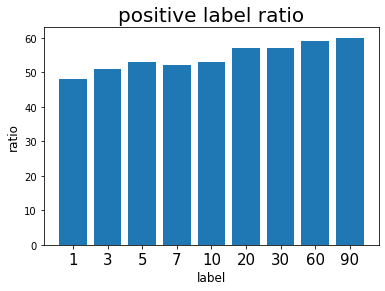

In [17]:
index = np.arange(len(n_list))
plt.bar(index, ratio_list)
plt.title('positive label ratio',fontsize=20)
plt.xlabel('label', fontsize=12)
plt.ylabel('ratio',fontsize=12)
plt.xticks(index,n_list, fontsize=15)
plt.show()

# Prediction

In [18]:
# 가격데이터
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return','Close','next_rtn']
# 기술지표 데이터
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR','middle']
# 시장지표 데이터
feature3_list = ['S&P500', 'SOX', 'VIX','KOSPI']
# 라벨링에 사용할 데이터
feature4_list = ['next_price']
# 기술지표 중 가격 정보가 덜 드러나는 데이터 
feature5_list = ['CCI','ATR','MACD','MTM1','MTM3','ROC','WPR']
# 기술지표 중 가격 정보가 드러나는 데이터
feature6_list = ['RASD5','RASD10','MA5','MA10','ub','lb','middle']
all_x_feature = feature1_list+feature2_list+feature3_list

## trn 7 tst 3

In [19]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[all_x_feature]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.3, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.480 test : 0.480	label1 정확도: 0.530
Lable3 양성비율 train : 0.506 test : 0.506	label3 정확도: 0.638
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.743
Lable7 양성비율 train : 0.522 test : 0.523	label7 정확도: 0.784
Lable10 양성비율 train : 0.535 test : 0.535	label10 정확도: 0.838
Lable20 양성비율 train : 0.571 test : 0.570	label20 정확도: 0.891
Lable30 양성비율 train : 0.572 test : 0.573	label30 정확도: 0.922
Lable60 양성비율 train : 0.586 test : 0.587	label60 정확도: 0.948
Lable90 양성비율 train : 0.603 test : 0.604	label90 정확도: 0.952


## trn 8 tst 2

In [22]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[all_x_feature]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2,stratify=y, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.535
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.687
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.748
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.803
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.844
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.928
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.939
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.953
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.962


## 기술지표만으로 예측

In [25]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature2_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.512
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.634
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.746
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.786
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.835
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.892
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.903
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.943
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.918


### 기술지표로 예측2
기술지표중 가격데이터의 특징이 크게 드러나지않는 지표로만 예측해본다.

In [34]:
print(feature5_list)

['CCI', 'ATR', 'MACD', 'MTM1', 'MTM3', 'ROC', 'WPR']


In [33]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature5_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.503
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.586
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.628
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.693
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.687
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.710
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.732
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.755
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.774


## 기술지표로 예측3

In [37]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature6_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.497
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.584
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.687
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.740
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.780
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.833
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.841
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.873
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.888


## 시장지표만으로 예측

In [26]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature3_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.510
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.577
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.636
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.710
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.742
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.803
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.810
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.869
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.873


## 가격 데이터만으로 예측

In [27]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature1_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.541
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.584
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.590
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.609
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.638
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.668
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.643
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.693
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.727


## 기술지표 + 시장지표만으로 예측

In [30]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature2_list+feature3_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.537
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.691
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.780
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.805
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.850
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.909
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.922
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.934
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.947


### 기술지표2 + 시장지표로 예측

In [35]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature5_list+feature3_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.535
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.677
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.723
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.774
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.808
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.875
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.913
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.930
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.943


### 기술지표3 + 시장지표

In [39]:
y_test_list = []
y_pred_list = []

if set(df.columns[:27]) == set(all_x_feature + feature4_list):
    X = df[feature6_list+feature3_list]
    
    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')
        
        y_test_list.append(y_test)
        
        forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
        forest.fit(X_train,y_train)
        y_pred = forest.predict(X_test)
        
        y_pred_list.append(y_pred)

        print(label_name,'정확도: %.3f' % accuracy_score(y_test, y_pred))

Lable1 양성비율 train : 0.478 test : 0.488	label1 정확도: 0.482
Lable3 양성비율 train : 0.503 test : 0.520	label3 정확도: 0.605
Lable5 양성비율 train : 0.526 test : 0.526	label5 정확도: 0.721
Lable7 양성비율 train : 0.526 test : 0.510	label7 정확도: 0.751
Lable10 양성비율 train : 0.539 test : 0.518	label10 정확도: 0.820
Lable20 양성비율 train : 0.575 test : 0.552	label20 정확도: 0.875
Lable30 양성비율 train : 0.582 test : 0.533	label30 정확도: 0.879
Lable60 양성비율 train : 0.592 test : 0.562	label60 정확도: 0.918
Lable90 양성비율 train : 0.606 test : 0.590	label90 정확도: 0.934
